In [1]:
from google.colab import files
files.upload()  # Upload the kaggle.json file


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"weldesemayatteklay","key":"7565d11d55061420be866a2be454e94e"}'}

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


In [3]:
!pip install kaggle


In [4]:
!kaggle datasets download -d uwrfkaggler/ravdess-emotional-speech-audio


Dataset URL: https://www.kaggle.com/datasets/uwrfkaggler/ravdess-emotional-speech-audio
License(s): CC-BY-NC-SA-4.0
 88% 376M/429M [00:03<00:00, 111MB/s] 
100% 429M/429M [00:03<00:00, 140MB/s]


In [5]:
import zipfile

with zipfile.ZipFile("ravdess-emotional-speech-audio.zip", 'r') as zip_ref:
    zip_ref.extractall("ravdess")


In [6]:
DATA_PATH = "ravdess"

In [7]:
# Install necessary packages
!pip install librosa soundfile kaggle


In [16]:
# Core libraries
import os
import numpy as np
import librosa
import soundfile as sf
import matplotlib.pyplot as plt

# ML tools
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Deep learning
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping


In [17]:
# Map emotion codes from filenames to emotion labels
emotion_map = {
    '01': 'neutral', '02': 'calm', '03': 'happy', '04': 'sad',
    '05': 'angry', '06': 'fearful', '07': 'disgust', '08': 'surprised'
}

# Extract rich audio features: MFCCs, Chroma, Spectral Contrast, Tonnetz
def extract_features(file_path):
    audio, sr = librosa.load(file_path, duration=3, offset=0.5)

    # MFCCs
    mfccs = np.mean(librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=40).T, axis=0)

    # Chroma
    stft = np.abs(librosa.stft(audio))
    chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)

    # Spectral Contrast
    contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)

    # Tonnetz
    tonnetz = np.mean(librosa.feature.tonnetz(y=librosa.effects.harmonic(audio), sr=sr).T, axis=0)

    # Combine all features
    return np.concatenate((mfccs, chroma, contrast, tonnetz))


In [18]:
features = []
labels = []
DATA_PATH = "ravdess"

# Loop through all audio files and extract features
for root, _, files in os.walk(DATA_PATH):
    for file in files:
        if file.endswith('.wav'):
            emotion_code = file.split('-')[2]
            emotion = emotion_map.get(emotion_code)
            file_path = os.path.join(root, file)
            try:
                mfcc = extract_features(file_path)
                features.append(mfcc)
                labels.append(emotion)
            except Exception as e:
                print(f"Error processing {file_path}: {e}")


/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1001
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=1012
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=989
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=966
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=943
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266: UserWarning: n_fft=1024 is too large for input signal of length=978
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/librosa/core/spectrum.py:266

In [19]:
# Convert to NumPy arrays
X = np.array(features)
y = np.array(labels)

# Encode emotion labels to integers
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_categorical = to_categorical(y_encoded)

# Normalize features for better model performance
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [20]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_categorical, test_size=0.2, random_state=42, stratify=y_categorical
)


In [21]:
# Define a fully connected neural network with dropout and batch normalization
model = Sequential()
model.add(Dense(512, activation='relu', input_shape=(X_scaled.shape[1],)))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(y_categorical.shape[1], activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 512)            │        33,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 8)              │         1,032 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 201,096 (785.53 KB)

 Trainable params: 200,072 (781.53 KB)

 Non-trainable params: 1,024 (4.00 KB)

In [22]:
# Stop training if validation loss doesn't improve for 10 epochs
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stop])


Epoch 1/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 5s 11ms/step - accuracy: 0.1978 - loss: 2.5251 - val_accuracy: 0.4115 - val_loss: 1.7878
Epoch 2/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.3690 - loss: 1.7303 - val_accuracy: 0.5087 - val_loss: 1.5673
Epoch 3/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.4449 - loss: 1.4995 - val_accuracy: 0.5660 - val_loss: 1.3457
Epoch 4/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5001 - loss: 1.3099 - val_accuracy: 0.5764 - val_loss: 1.1856
Epoch 5/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.5565 - loss: 1.2494 - val_accuracy: 0.6285 - val_loss: 1.0025
Epoch 6/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.5978 - loss: 1.1188 - val_accuracy: 0.6528 - val_loss: 0.9383
Epoch 7/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6262 - loss: 1.0223 - val_accuracy: 0.7083 - val_loss: 0.8151
Epoch 8/100
72/72 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6299 - loss: 0.9996 - val_accuracy: 0.7326 - 

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
              precision    recall  f1-score   support

       angry       0.92      0.95      0.94        77
        calm       0.97      0.94      0.95        77
     disgust       0.97      0.90      0.93        77
     fearful       0.97      0.97      0.97        77
       happy       0.92      0.92      0.92        77
     neutral       0.84      0.95      0.89        38
         sad       0.92      0.95      0.94        77
   surprised       0.97      0.97      0.97        76

    accuracy                           0.94       576
   macro avg       0.94      0.94      0.94       576
weighted avg       0.94      0.94      0.94       576



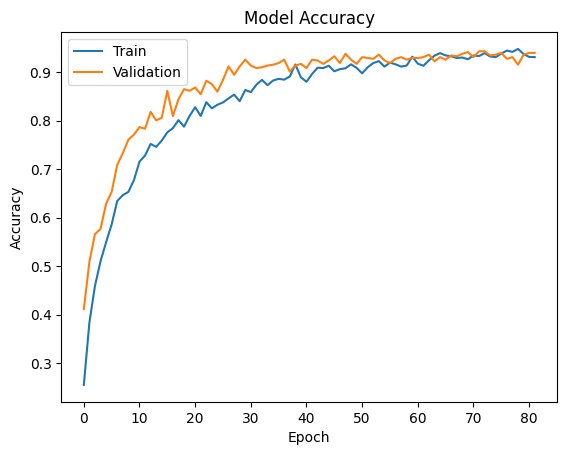

In [23]:
# Predict and decode predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Print classification report
print(classification_report(y_true_classes, y_pred_classes, target_names=le.classes_))

# Plot training vs validation accuracy
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [25]:
# Save the trained model to my Colab environment
model.save('/content/emotion_model_ravdess_enhanced.keras')
print("Enhanced model saved successfully!")


Enhanced model saved successfully!
